# 丁香园新冠数据分析

丁香园实时网站：https://ncov.dxy.cn/ncovh5/view/pneumonia

In [1]:
import pandas as pd
import matplotlib.font_manager as mfm
import matplotlib.pyplot as plt
font_path = './STFANGSO.TTF'
font_prop = mfm.FontProperties(fname=font_path)

In [2]:
data = pd.read_csv('../DXYArea.csv')
data['updateTime'] = pd.to_datetime(data['updateTime'])  # original type of updateTime after read_csv is 'str'
data['updateDate'] = data['updateTime'].dt.date    # add date for daily aggregation

In [3]:
print('Last Update: ', data['updateTime'].max())
print('Date Range: ', data['updateDate'].min(), 'to', data['updateDate'].max())
print('Total rows: ', data.shape[0])

Last Update:  2020-02-04 13:28:05.653000
Date Range:  2020-01-24 to 2020-02-04
Total rows:  15192


In [4]:
data.head()

,provinceName,cityName,province_confirmedCount,province_suspectedCount,province_curedCount,province_deadCount,city_confirmedCount,city_suspectedCount,city_curedCount,city_deadCount,updateTime,updateDate
0,安徽省,合肥,480,0,20,0,81,0,5,0,2020-02-04 13:28:05.653,2020-02-04
1,安徽省,阜阳,480,0,20,0,79,0,3,0,2020-02-04 13:28:05.653,2020-02-04
2,安徽省,安庆,480,0,20,0,55,0,3,0,2020-02-04 13:28:05.653,2020-02-04
3,安徽省,亳州,480,0,20,0,48,0,2,0,2020-02-04 13:28:05.653,2020-02-04
4,安徽省,蚌埠,480,0,20,0,43,0,0,0,2020-02-04 13:28:05.653,2020-02-04


## 把实时数据整合成每日数据

In [5]:
def aggDaily(df):
    frm_list = []
    drop_cols = ['province_' + field for field in ['confirmedCount', 'suspectedCount', 'curedCount', 'deadCount']]  # these can be computed later
    for key, frm in df.drop(columns=drop_cols).sort_values(['updateDate']).groupby(['cityName', 'updateDate']):
        frm_list.append(frm.sort_values(['updateTime'])[-1:])    # take the lastest row within (city, date)
    out = pd.concat(frm_list).sort_values(['updateDate', 'provinceName', 'cityName'])
    to_names = [field for field in ['confirmed', 'suspected', 'cured', 'dead']]
    out = out.rename(columns=dict([('city_' + d + 'Count', d) for d in to_names]))
    return out

In [6]:
daily_frm = aggDaily(data)

In [7]:
daily_frm

,provinceName,cityName,confirmed,suspected,cured,dead,updateTime,updateDate
14202,云南省,丽江市,1,0,0,0,2020-01-24 23:55:14.973,2020-01-24
14200,云南省,昆明,3,0,0,0,2020-01-24 23:55:14.973,2020-01-24
14201,云南省,西双版纳州,1,0,0,0,2020-01-24 23:55:14.973,2020-01-24
14546,内蒙古自治区,满洲里,1,0,0,0,2020-01-24 13:04:21.168,2020-01-24
15074,北京市,不明地区,8,0,0,0,2020-01-24 07:37:33.464,2020-01-24
...,...,...,...,...,...,...,...,...
424,黑龙江省,绥化,22,0,0,2,2020-02-04 08:44:24.550,2020-02-04
428,黑龙江省,鸡西,9,0,0,0,2020-02-04 08:44:24.550,2020-02-04
433,黑龙江省,鹤岗,2,0,0,0,2020-02-04 08:44:24.550,2020-02-04
434,黑龙江省,黑河,1,0,0,0,2020-02-04 08:44:24.550,2020-02-04


## 单个省份时间序列

In [8]:
province = '湖北省'   # 输入你所要的省份
agg = daily_frm[daily_frm['provinceName'] == province].drop(columns=['provinceName']).groupby(['updateDate']).agg('sum')
agg.tail(3)

,confirmed,suspected,cured,dead
updateDate,,,,
2020-02-02,9074,0,232,294
2020-02-03,11177,0,300,350
2020-02-04,13522,0,398,414


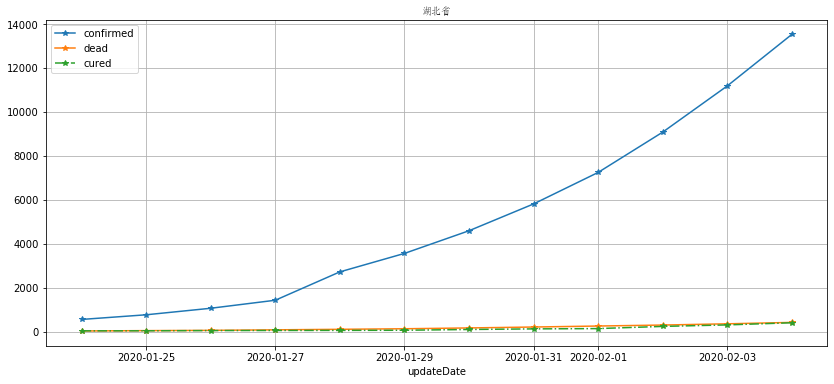

In [9]:
ax = agg.plot(y=['confirmed', 'dead', 'cured'], style=['-*', '-*', '-.*'], grid=True, figsize=(14,6))
ax.set_title(province, fontproperties=font_prop)
plt.show()

## 武汉 - 湖北（除武汉外） - 湖北以外 疫情对比

In [10]:
wuhan = daily_frm[daily_frm['cityName'] == '武汉'].groupby('updateDate').agg('sum')
hubei_exWuhan = daily_frm[(daily_frm['provinceName'] == '湖北省') & (daily_frm['cityName'] != '武汉')].groupby('updateDate').agg('sum')
outside_hubei = daily_frm[daily_frm['provinceName'] != '湖北省'].groupby('updateDate').agg('sum')

In [11]:
contrast_frm = pd.merge(wuhan.add_suffix('_Wuhan'), hubei_exWuhan.add_suffix('_Hubei_exWuhan'), 'left', on='updateDate')
contrast_frm = pd.merge(contrast_frm, outside_hubei.add_suffix('_outsideHubei'), 'left', on='updateDate')

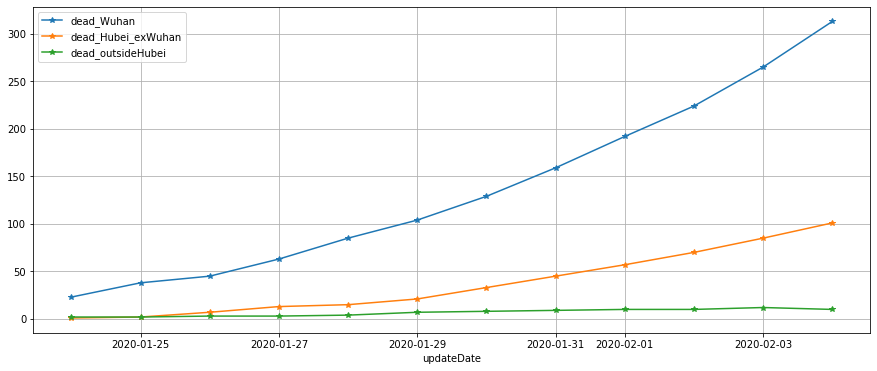

In [13]:
contrast_col = 'dead'    # you can pick other columns such as 'dead', 'cured'
contrast_frm.plot(y=[contrast_col + suffix for suffix in ('_Wuhan', '_Hubei_exWuhan', '_outsideHubei')], 
                       grid=True, figsize=(15, 6), style='-*')